In [1]:
%load_ext autoreload
%autoreload 2
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np

# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
# os.environ["BART_TOOLBOX_PATH"] = "/Users/chunxuguo/bart"
import torch
import torchopt
from einops import rearrange, reduce
from fastmri import complex_abs
from fastmri.data import mri_data, subsample, transforms
from omegaconf import OmegaConf

from ese5934_project.datasets.csm_estimation import espirit_csm_estimation
from ese5934_project.evaluate_metric import Evaluate_MT1, Evaluate_MT2
from ese5934_project.models.GridField import Grid
from ese5934_project.models.operators import (
    C_adj,
    F_adj,
    ForwardModel,
    MaskedForwardModel,
)
from ese5934_project.models.SIREN import Siren, get_coordinates
from ese5934_project.tasks.mri_reconstruction_2d import reconstruct

# Create a mask function

In [2]:
def data_transform_2(
    kspace,
    mask,
    target,
    data_attributes,
    filename,
    slice_num,
):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm


def data_transform_4(
    kspace,
    mask,
    target,
    data_attributes,
    filename,
    slice_num,
):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm


def data_transform_8(
    kspace,
    mask,
    target,
    data_attributes,
    filename,
    slice_num,
):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm


def data_transform_gt(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[1])
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm


dataset_gt = mri_data.SliceDataset(
    root=pathlib.Path("/bmrc-homes/nmrgrp/nmr219/ese5934_project/data"),
    transform=data_transform_gt,
    challenge="multicoil",
)
dataset_2 = mri_data.SliceDataset(
    root=pathlib.Path("/bmrc-homes/nmrgrp/nmr219/ese5934_project/data"),
    transform=data_transform_2,
    challenge="multicoil",
)
dataset_4 = mri_data.SliceDataset(
    root=pathlib.Path("/bmrc-homes/nmrgrp/nmr219/ese5934_project/data"),
    transform=data_transform_4,
    challenge="multicoil",
)
dataset_8 = mri_data.SliceDataset(
    root=pathlib.Path("/bmrc-homes/nmrgrp/nmr219/ese5934_project/data"),
    transform=data_transform_8,
    challenge="multicoil",
)

# get ground truth

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


Done.


(-0.5, 367.5, 639.5, -0.5)

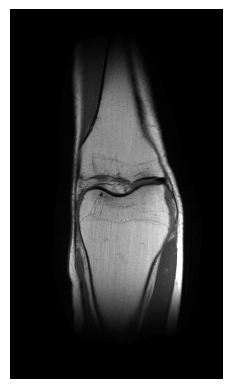

In [3]:
kspace, (mean, std), masked_kspace, mask, csm = dataset_gt[15]
f_adj = F_adj()
c_adj = C_adj()
image_gt = c_adj(f_adj(kspace), csm)
ground_truth_image = image_gt.squeeze()
from matplotlib import pyplot as plt

plt.imshow(torch.view_as_complex(image_gt).abs()[0], cmap="gray", vmax=25)
plt.axis("off")

# Best Case Images with Acceleration Rate of 4

## Grid Field (Voxel Representation)

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


Done.


ic| params.keys(): dict_keys(['grid'])


(-0.5, 367.5, 639.5, -0.5)

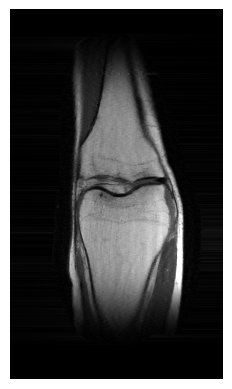

In [4]:
scheduler = lambda t: 0.8 ** (t // 400) * 1e-1
optimizer = torchopt.adam(lr=0.1)
kspace, (mean, std), masked_kspace, mask, csm = dataset_4[15]
field = Grid((640, 368), mean, std)
params, image_list_ADAM = reconstruct(
    field,
    torch.rand(1, 2),
    masked_kspace,
    csm,
    mask,
    alpha=0.005,
    optimizer=optimizer,
    iterations=4000,
    device=torch.device("cuda"),
)
plt.imshow(complex_abs(image_list_ADAM[-1]), cmap="gray", vmax=25)
plt.axis("off")

## SIREN

/bmrc-homes/nmrgrp/nmr201/micromamba/envs/python311/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['net.0.linear.weight', 'net.0.linear.bias', 'net.1.linear.weight', 'net.1.linear.bias', 'net.2.linear.weight', 'net.2.linear.bias', 'net.3.linear.weight', 'net.3.linear.bias', 'net.4.linear.weight', 'net.4.linear.bias', 'net.5.weight', 'net.5.bias'])


Done.


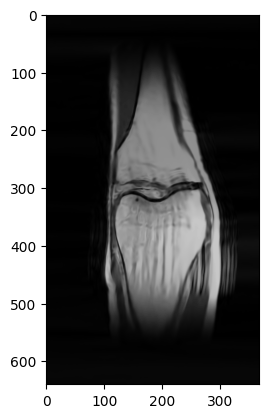

In [6]:
device = torch.device("cuda")
size = (640, 368)
from ese5934_project.models.SIREN import Siren, get_coordinates

coords = get_coordinates(size)
kspace, (mean, std), masked_kspace, mask, csm = dataset_4[15]
field = Siren(
    size,
    mean.to(device),
    std.to(device),
    in_features=2,
    out_features=2,
    hidden_features=256,
    hidden_layers=4,
    outermost_linear=True,
    first_omega_0=25,
    hidden_omega_0=25,
)
lr_scheduler = lambda t: 0.8 ** (t // 400) * 1e-4
optimizer = torchopt.adamw(lr=lr_scheduler)
# 1e-4 1.092077389
# 1e-3 0.08540542
params, image_list_SIREN = reconstruct(
    field,
    coords,
    masked_kspace,
    csm,
    mask,
    alpha=0.01,
    optimizer=optimizer,
    iterations=4000,
    device=device,
)
plt.imshow(complex_abs(image_list_SIREN[-1]), cmap="gray", vmax=25)

## DictField

ic| self.basis_dims: array([32, 32, 32, 16, 16, 16])
ic| self.basis_reso: array([16, 26, 35, 45, 54, 64])
ic| self.bbox: tensor([[  0.,   0.],
                       [640., 368.]], device='cuda:0')
ic| self.coeff_reso: [40, 24]
ic| coeffs.shape: torch.Size([1, 144, 40, 24])
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 16, 16]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 26, 26]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 35, 35]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 45, 45]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 54, 54]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 64, 64]


=====> total parameters:  361264
tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['coeffs', 'basises.0', 'basises.1', 'basises.2', 'basises.3', 'basises.4', 'basises.5', 'linear_mat.backbone.0.weight', 'linear_mat.backbone.0.bias', 'linear_mat.backbone.1.weight'])


Done.
iteration 1, dc_loss: 2.9792377948760986, tv_loss: 7.349102816078812e-05
iteration 2, dc_loss: 2.9729835987091064, tv_loss: 0.00019470005645416677
iteration 3, dc_loss: 2.9666202068328857, tv_loss: 0.0003167290415149182
iteration 4, dc_loss: 2.9602725505828857, tv_loss: 0.00043874196126125753
iteration 5, dc_loss: 2.953824043273926, tv_loss: 0.0005637682625092566
iteration 6, dc_loss: 2.947174072265625, tv_loss: 0.0006920791347511113
iteration 7, dc_loss: 2.9403083324432373, tv_loss: 0.0008243373013101518
iteration 8, dc_loss: 2.9331324100494385, tv_loss: 0.0009631947032175958
iteration 9, dc_loss: 2.925509452819824, tv_loss: 0.0011102133430540562
iteration 10, dc_loss: 2.9172921180725098, tv_loss: 0.0012656308244913816
iteration 11, dc_loss: 2.9083616733551025, tv_loss: 0.001429490395821631
iteration 12, dc_loss: 2.8985307216644287, tv_loss: 0.0016029769321903586
iteration 13, dc_loss: 2.8875598907470703, tv_loss: 0.0017875045305117965
iteration 14, dc_loss: 2.875255823135376, t

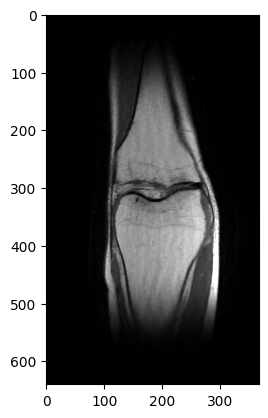

In [12]:
# from torch.utils.data import DataLoader
# from datalo

from ese5934_project.models.FactorFields import DictField, get_coordinates

base_conf = OmegaConf.load("/bmrc-an-data/Chunxu/ese5934_project/configs/defaults.yaml")
second_conf = OmegaConf.load("/bmrc-an-data/Chunxu/ese5934_project/configs/image.yaml")
cfg = OmegaConf.merge(
    base_conf,
    second_conf,
)

device = torch.device("cuda:0")
size = (640, 368)
model = DictField(cfg, size, device)
coords = get_coordinates(size)
kspace, (mean, std), masked_kspace, mask, csm = dataset_4[15]

scheduler = lambda t: 0.8 ** (t // 400) * 5e-3
optimizer = torchopt.adam(lr=scheduler)

params, image_list = reconstruct(
    model,
    coords,
    masked_kspace,
    csm,
    mask,
    alpha=0.005,
    optimizer=optimizer,
    iterations=4000,
    device=device,
    verbose=True,
)
plt.imshow(complex_abs(image_list[-1]), cmap="gray", vmax=25)

In [14]:
results = {
    "ADAM": image_list_ADAM[-1],
    # "SIREN": image_list_SIREN[-1],
    "DF": image_list[-1],
    "gt": image_gt.squeeze(),
}
torch.save(results, "experiments/best_case_comparision/images_dict.pt")
psnr_dict = {
    key: Evaluate_MT1(image_gt, value)[0]
    for key, value in results.items()
    if key != "gt"
}
torch.save(psnr_dict, "experiments/best_case_comparision/psnr_dict.pt")
ssim_dict = {
    key: Evaluate_MT1(image_gt, value)[1]
    for key, value in results.items()
    if key != "gt"
}
torch.save(ssim_dict, "experiments/best_case_comparision/ssim_dict.pt")

PSNR Value mt1: 36.12320252630849
SSIM Value mt1: 0.7842791778076317
PSNR Value mt1: 38.20538190060181
SSIM Value mt1: 0.9346172397449728
PSNR Value mt1: 36.12320252630849
SSIM Value mt1: 0.7842791778076317
PSNR Value mt1: 38.20538190060181
SSIM Value mt1: 0.9346172397449728


# Different ARs

In [15]:
import pandas as pd

ADAM_list = []
SIREN_list = []
DF_list = []
datasets_list = [dataset_gt, dataset_2, dataset_4, dataset_8]
# results = pd.DataFrame(
#     columns=[
#         "acceration_rate",
#         "psnr",
#         "ssim",
#     ],
#     index=[
#         "ADAM",
#         "SIREN",
#         "DF",
#     ],
# )
# results.loc["ADAM", "psnr"] = 0

In [18]:
for dataset, ar in zip(datasets_list, [1, 2, 4, 8]):
    scheduler = lambda t: 0.8 ** (t // 400) * 1e-1
    optimizer = torchopt.adam(lr=0.1)
    kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
    field = Grid((640, 368), mean, std)
    params, image_list_ADAM = reconstruct(
        field,
        torch.rand(1, 2),
        masked_kspace,
        csm,
        mask,
        alpha=0.005,
        optimizer=optimizer,
        iterations=4000,
        device=torch.device("cuda"),
    )
    psnr, ssim = Evaluate_MT1(image_gt, image_list_ADAM[-1])
    ADAM_list.append((psnr, ssim))

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['grid'])


Done.
PSNR Value mt1: 49.782543219055206
SSIM Value mt1: 0.9552465639139732
tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['grid'])


Done.
PSNR Value mt1: 35.81746788119504
SSIM Value mt1: 0.7832948340974734
tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['grid'])


Done.
PSNR Value mt1: 36.20641452968033
SSIM Value mt1: 0.7780212330974999
tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['grid'])


Done.
PSNR Value mt1: 34.87135346651343
SSIM Value mt1: 0.7606510936766294


In [19]:
print(ADAM_list)

[(49.782543219055206, 0.9552465639139732), (35.81746788119504, 0.7832948340974734), (36.20641452968033, 0.7780212330974999), (34.87135346651343, 0.7606510936766294)]


In [25]:
import pandas as pd

d = pd.DataFrame(
    {
        "Acceleration Rate": [1, 2, 4, 8],
        "PSNR": [n[0] for n in ADAM_list],
        "SSIM": [n[1] for n in ADAM_list],
    }
)
d.to_csv("experiments/different_AR/ADAM.csv")

In [26]:
for dataset, ar in zip(datasets_list, [1, 2, 4, 8]):
    device = torch.device("cuda")
    size = (640, 368)
    from ese5934_project.models.SIREN import Siren, get_coordinates

    coords = get_coordinates(size)
    kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
    field = Siren(
        size,
        mean.to(device),
        std.to(device),
        in_features=2,
        out_features=2,
        hidden_features=256,
        hidden_layers=4,
        outermost_linear=True,
        first_omega_0=25,
        hidden_omega_0=25,
    )
    lr_scheduler = lambda t: 0.8 ** (t // 400) * 1e-4
    optimizer = torchopt.adamw(lr=lr_scheduler)
    # 1e-4 1.092077389
    # 1e-3 0.08540542
    params, image_list_SIREN = reconstruct(
        field,
        coords,
        masked_kspace,
        csm,
        mask,
        alpha=0.01,
        optimizer=optimizer,
        iterations=4000,
        device=device,
    )
    psnr, ssim = Evaluate_MT1(image_gt, image_list_ADAM[-1])
    SIREN_list.append((psnr, ssim))

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['net.0.linear.weight', 'net.0.linear.bias', 'net.1.linear.weight', 'net.1.linear.bias', 'net.2.linear.weight', 'net.2.linear.bias', 'net.3.linear.weight', 'net.3.linear.bias', 'net.4.linear.weight', 'net.4.linear.bias', 'net.5.weight', 'net.5.bias'])


Done.
iteration 1, dc_loss: 3.18599009513855, tv_loss: 0.0005901351105421782
iteration 2, dc_loss: 3.0555496215820312, tv_loss: 0.003078893991187215
iteration 3, dc_loss: 2.9740359783172607, tv_loss: 0.005541853606700897
iteration 4, dc_loss: 2.9173800945281982, tv_loss: 0.007393249310553074
iteration 5, dc_loss: 2.8812050819396973, tv_loss: 0.00861265230923891
iteration 6, dc_loss: 2.8570971488952637, tv_loss: 0.009377313777804375
iteration 7, dc_loss: 2.8397624492645264, tv_loss: 0.00983405765146017
iteration 8, dc_loss: 2.8248579502105713, tv_loss: 0.010136129334568977
iteration 9, dc_loss: 2.8094234466552734, tv_loss: 0.010419312864542007
iteration 10, dc_loss: 2.793241500854492, tv_loss: 0.010728083550930023
iteration 11, dc_loss: 2.7774014472961426, tv_loss: 0.011017663404345512
iteration 12, dc_loss: 2.7619478702545166, tv_loss: 0.011285373941063881
iteration 13, dc_loss: 2.7462716102600098, tv_loss: 0.01155644841492176
iteration 14, dc_loss: 2.7313075065612793, tv_loss: 0.01181

ic| params.keys(): dict_keys(['net.0.linear.weight', 'net.0.linear.bias', 'net.1.linear.weight', 'net.1.linear.bias', 'net.2.linear.weight', 'net.2.linear.bias', 'net.3.linear.weight', 'net.3.linear.bias', 'net.4.linear.weight', 'net.4.linear.bias', 'net.5.weight', 'net.5.bias'])


Done.
iteration 1, dc_loss: 2.953230619430542, tv_loss: 0.0003438346029724926
iteration 2, dc_loss: 2.824640989303589, tv_loss: 0.003585376078262925
iteration 3, dc_loss: 2.749671697616577, tv_loss: 0.006073945667594671
iteration 4, dc_loss: 2.7008719444274902, tv_loss: 0.00792218092828989
iteration 5, dc_loss: 2.671436071395874, tv_loss: 0.009071550332009792
iteration 6, dc_loss: 2.6513469219207764, tv_loss: 0.009749146178364754
iteration 7, dc_loss: 2.63533616065979, tv_loss: 0.010172576643526554
iteration 8, dc_loss: 2.6196398735046387, tv_loss: 0.010546237230300903
iteration 9, dc_loss: 2.6034185886383057, tv_loss: 0.010917861945927143
iteration 10, dc_loss: 2.5874154567718506, tv_loss: 0.011237578466534615
iteration 11, dc_loss: 2.571352243423462, tv_loss: 0.011504360474646091
iteration 12, dc_loss: 2.5555624961853027, tv_loss: 0.011751309037208557
iteration 13, dc_loss: 2.540461301803589, tv_loss: 0.012014058418571949
iteration 14, dc_loss: 2.5259487628936768, tv_loss: 0.01230798

ic| params = dict(fi: dict_keys(['net.0.linear.weight', 'net.0.linear.bias', 'net.1.linear.weight', 'net.1.linear.bias', 'net.2.linear.weight', 'net.2.linear.bias', 'net.3.linear.weight', 'net.3.linear.bias', 'net.4.linear.weight', 'net.4.linear.bias', 'net.5.weight', 'net.5.bias'])


Done.
iteration 1, dc_loss: 3.005403518676758, tv_loss: 0.0005004759877920151
iteration 2, dc_loss: 2.8783397674560547, tv_loss: 0.0033010724000632763
iteration 3, dc_loss: 2.8058218955993652, tv_loss: 0.005649450235068798
iteration 4, dc_loss: 2.7543725967407227, tv_loss: 0.007261334452778101
iteration 5, dc_loss: 2.715136766433716, tv_loss: 0.008402793668210506
iteration 6, dc_loss: 2.6857385635375977, tv_loss: 0.009193306788802147
iteration 7, dc_loss: 2.664520263671875, tv_loss: 0.009729486890137196
iteration 8, dc_loss: 2.647268533706665, tv_loss: 0.010113631375133991
iteration 9, dc_loss: 2.6308071613311768, tv_loss: 0.010357657447457314
iteration 10, dc_loss: 2.614577054977417, tv_loss: 0.010506504215300083
iteration 11, dc_loss: 2.5979108810424805, tv_loss: 0.010666261427104473
iteration 12, dc_loss: 2.582097291946411, tv_loss: 0.010824855417013168
iteration 13, dc_loss: 2.567143678665161, tv_loss: 0.010946669615805149
iteration 14, dc_loss: 2.552508592605591, tv_loss: 0.011023

ic| params = dict(fi: dict_keys(['net.0.linear.weight', 'net.0.linear.bias', 'net.1.linear.weight', 'net.1.linear.bias', 'net.2.linear.weight', 'net.2.linear.bias', 'net.3.linear.weight', 'net.3.linear.bias', 'net.4.linear.weight', 'net.4.linear.bias', 'net.5.weight', 'net.5.bias'])


Done.
iteration 1, dc_loss: 2.935042142868042, tv_loss: 0.0008581512374803424
iteration 2, dc_loss: 2.813906192779541, tv_loss: 0.004346647299826145
iteration 3, dc_loss: 2.748802423477173, tv_loss: 0.0064378357492387295
iteration 4, dc_loss: 2.7061820030212402, tv_loss: 0.007817002013325691
iteration 5, dc_loss: 2.6745200157165527, tv_loss: 0.008727215230464935
iteration 6, dc_loss: 2.6500349044799805, tv_loss: 0.009370515123009682
iteration 7, dc_loss: 2.6297852993011475, tv_loss: 0.009868411347270012
iteration 8, dc_loss: 2.611405849456787, tv_loss: 0.010255226865410805
iteration 9, dc_loss: 2.594622850418091, tv_loss: 0.010551880113780499
iteration 10, dc_loss: 2.5781402587890625, tv_loss: 0.010800882242619991
iteration 11, dc_loss: 2.5617458820343018, tv_loss: 0.010989588685333729
iteration 12, dc_loss: 2.5462396144866943, tv_loss: 0.011076439172029495
iteration 13, dc_loss: 2.531658172607422, tv_loss: 0.01109855342656374
iteration 14, dc_loss: 2.517054796218872, tv_loss: 0.011168

In [20]:
from ese5934_project.models.FactorFields import DictField, get_coordinates

base_conf = OmegaConf.load("/bmrc-an-data/Chunxu/ese5934_project/configs/defaults.yaml")
second_conf = OmegaConf.load("/bmrc-an-data/Chunxu/ese5934_project/configs/image.yaml")
cfg = OmegaConf.merge(
    base_conf,
    second_conf,
)
for dataset, ar in zip(datasets_list, [1, 2, 4, 8]):
    device = torch.device("cuda:1")
    size = (640, 368)
    model = DictField(cfg, size, device)

    coords = get_coordinates(size)
    kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
    scheduler = lambda t: 0.8 ** (t // 400) * 5e-3
    optimizer = torchopt.adam(lr=scheduler)

    params, image_list = reconstruct(
        model,
        coords,
        masked_kspace,
        csm,
        mask,
        alpha=0.005,
        optimizer=optimizer,
        iterations=4000,
        device=device,
    )
    psnr, ssim = Evaluate_MT1(image_gt, image_list_ADAM[-1])
    DF_list.append((psnr, ssim))

ic| self.basis_dims: array([32, 32, 32, 16, 16, 16])
ic| self.basis_reso: array([16, 26, 35, 45, 54, 64])


ic| self.bbox: tensor([[  0.,   0.],
                       [640., 368.]], device='cuda:1')
ic| self.coeff_reso: [40, 24]
ic| coeffs.shape: torch.Size([1, 144, 40, 24])
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 16, 16]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 26, 26]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 35, 35]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 45, 45]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 54, 54]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 64, 64]


=====> total parameters:  361264
tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['coeffs', 'basises.0', 'basises.1', 'basises.2', 'basises.3', 'basises.4', 'basises.5', 'linear_mat.backbone.0.weight', 'linear_mat.backbone.0.bias', 'linear_mat.backbone.1.weight'])


Done.


ic| self.basis_dims: array([32, 32, 32, 16, 16, 16])
ic| self.basis_reso: array([16, 26, 35, 45, 54, 64])
ic| self.bbox: tensor([[  0.,   0.],
                       [640., 368.]], device='cuda:1')
ic| self.coeff_reso: [40, 24]
ic| coeffs.shape: torch.Size([1, 144, 40, 24])
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 16, 16]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 26, 26]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 35, 35]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 45, 45]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 54, 54]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 64, 64]


PSNR Value mt1: 34.87135346651343
SSIM Value mt1: 0.7606510936766294
=====> total parameters:  361264
tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['coeffs', 'basises.0', 'basises.1', 'basises.2', 'basises.3', 'basises.4', 'basises.5', 'linear_mat.backbone.0.weight', 'linear_mat.backbone.0.bias', 'linear_mat.backbone.1.weight'])


Done.


ic| self.basis_dims: array([32, 32, 32, 16, 16, 16])
ic| self.basis_reso: array([16, 26, 35, 45, 54, 64])
ic| self.bbox: tensor([[  0.,   0.],
                       [640., 368.]], device='cuda:1')
ic| self.coeff_reso: [40, 24]
ic| coeffs.shape: torch.Size([1, 144, 40, 24])
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 16, 16]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 26, 26]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 35, 35]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 45, 45]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 54, 54]
ic

PSNR Value mt1: 34.87135346651343
SSIM Value mt1: 0.7606510936766294


| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 64, 64]


=====> total parameters:  361264
tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['coeffs', 'basises.0', 'basises.1', 'basises.2', 'basises.3', 'basises.4', 'basises.5', 'linear_mat.backbone.0.weight', 'linear_mat.backbone.0.bias', 'linear_mat.backbone.1.weight'])


Done.


ic| self.basis_dims: array([32, 32, 32, 16, 16, 16])
ic| self.basis_reso: array([16, 26, 35, 45, 54, 64])
ic| self.bbox: tensor([[  0.,   0.],
                       [640., 368.]], device='cuda:1')
ic| self.coeff_reso: [40, 24]
ic| coeffs.shape: torch.Size([1, 144, 40, 24])
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 16, 16]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 26, 26]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 35, 35]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 45, 45]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 54, 54]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 64, 64]


PSNR Value mt1: 34.87135346651343
SSIM Value mt1: 0.7606510936766294
=====> total parameters:  361264
tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['coeffs', 'basises.0', 'basises.1', 'basises.2', 'basises.3', 'basises.4', 'basises.5', 'linear_mat.backbone.0.weight', 'linear_mat.backbone.0.bias', 'linear_mat.backbone.1.weight'])


Done.
PSNR Value mt1: 34.87135346651343
SSIM Value mt1: 0.7606510936766294


In [21]:
print(DF_list)

[(34.87135346651343, 0.7606510936766294), (34.87135346651343, 0.7606510936766294), (34.87135346651343, 0.7606510936766294), (34.87135346651343, 0.7606510936766294)]


In [28]:
torch.save(
    {"ADAM": ADAM_list, "SIREN": SIREN_list, "DF": DF_list}, "results_AR_1_2_4_8.pt"
)

In [32]:
print(DF_list)

[(35.239742876024216, 0.7594775679989919), (35.239742876024216, 0.7594775679989919), (35.239742876024216, 0.7594775679989919), (35.239742876024216, 0.7594775679989919), (35.77876077524474, 0.7715722252164936), (35.77876077524474, 0.7715722252164936), (35.77876077524474, 0.7715722252164936), (35.77876077524474, 0.7715722252164936)]


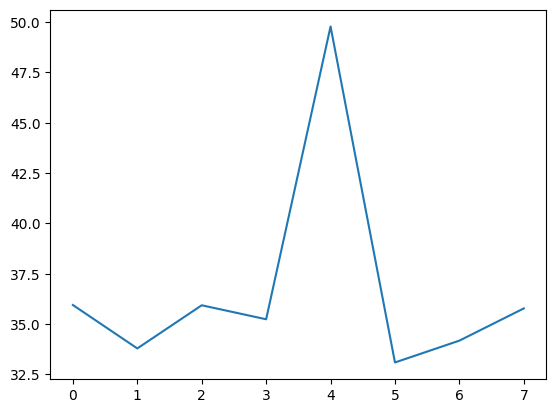

In [33]:
plt.plot([d[0] for d in ADAM_list])

In [ ]:
results.to_excel("experiments/AR_results.xlsx")

ModuleNotFoundError: No module named 'openpyxl'

In [89]:
for k, v in results.items():
    print(k)
    Evaluate_MT1(image_gt, v)

ADAM
PSNR Value mt1: 35.51589318336404
SSIM Value mt1: 0.7751314202416238
SIREN
PSNR Value mt1: 28.169658116720203
SSIM Value mt1: 0.8022582995267628
DF
PSNR Value mt1: 38.49677393524084
SSIM Value mt1: 0.9359180332422214
gt
PSNR Value mt1: inf
SSIM Value mt1: 1.0


/bmrc-homes/nmrgrp/nmr201/micromamba/envs/python311/lib/python3.11/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)


In [71]:
Evaluate_MT2(image_gt, image_list[-1])

PSNR Value mt2: 37.331352482059785
SSIM Value mt2: 0.9279717622379655


(37.331352482059785, 0.9279717622379655)